<a href="https://colab.research.google.com/github/lanukahjo/Image-Splicing-Localisation/blob/main/Image_Splicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Splicing Localisation
#### This notebook is the main flow of execution

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

import implice
import metrics

In [10]:
#This script runs a script to create random spliced images from a given set of 180 authentic images
#The authentic files are supposed to have names 1.bmp, 2.bmp etc
# %run generate_random_spliced_imageset.py 

C:\Users\Kunal\Labs&Codes\Image-Splicing-Localisation\generate_random_spliced_imageset.py:75: UserWarning: C:\Users\Kunal\Labs&Codes\Image-Splicing-Localisation/Dataset/Spliced//48_S.bmp is a low contrast image
  io.imsave(os.getcwd() + '/Dataset/Spliced/' + base_file_name + '_S.bmp',spliced_img)


Reading the file from the given location
manually for now.

In [20]:
# Constants used throughout the code

#filepaths for diksham1
#PATH_TO_AUTHENTIC_IMG = '/content/AU_S_003.bmp'
#PATH_TO_SPLICED_IMG = '/content/SP_S_003.bmp';

#filepaths for lanukahjo
PATH_TO_AUTHENTIC_IMG = os.getcwd() + '/Dataset/Authentic/119.bmp'
PATH_TO_SPLICED_IMG = os.getcwd() + '/Dataset/Spliced/119_S.bmp'

THRESHOLD = 0.2;
BLOCK_SIZE = 4;
STEP_SIZE = 2;
MINKOWSKI_DISTANCE_ORDER = 4;

In [21]:
spliced_region_output = implice.localise_spliced_area(PATH_TO_AUTHENTIC_IMG,PATH_TO_SPLICED_IMG)
output_img_euclidean_dist = spliced_region_output[0]
output_img_hellinger_dist = spliced_region_output[1]
output_img_minkowski_dist = spliced_region_output[2]

206

In [18]:
#Metric Calculation
#file = open(os.getcwd() + '/Dataset/spliced_area.csv','r')
#csvreader = csv.reader(file)
#rows = []
#for row in csvreader:
#    rows.append(row)
#file.close();

In [9]:
#metrics = metrics.getMetric(output_img_euclidean_dist,rows,119)
#metrics

(0, 13864, 0, 2520)

In [22]:
output_img_euclidean_dist = implice.paint_in_white(output_img_euclidean_dist)
output_img_euclidean_dist = implice.paint_in_white(output_img_hellinger_dist)
output_img_euclidean_dist = implice.paint_in_white(output_img_minkowski_dist)

###Assumption
- Images are already in grayscale format (0-255)


In [23]:
# the text between the last '/' and the last '.' is the file name 
# assuming dataset's naming convention is followed
pos1 = PATH_TO_SPLICED_IMG.rindex("/")
pos2 = PATH_TO_SPLICED_IMG.rindex(".") 
base_file_name = PATH_TO_SPLICED_IMG[pos1:pos2]

#output filepath for diksham1
#io.imsave('euclidean.bmp', output_img_euclidean_dist)
#io.imsave('hellinger.bmp', output_img_hellinger_dist)
#io.imsave('minkowski.bmp', output_img_minkowski_dist)

#output filepath for lanukahjo
io.imsave(os.getcwd() + "/Dataset/Output" + base_file_name + "_S_E.bmp", output_img_euclidean_dist)
io.imsave(os.getcwd() + "/Dataset/Output" + base_file_name + "_S_H.bmp", output_img_hellinger_dist)
io.imsave(os.getcwd() + "/Dataset/Output" + base_file_name + "_S_M.bmp", output_img_minkowski_dist)


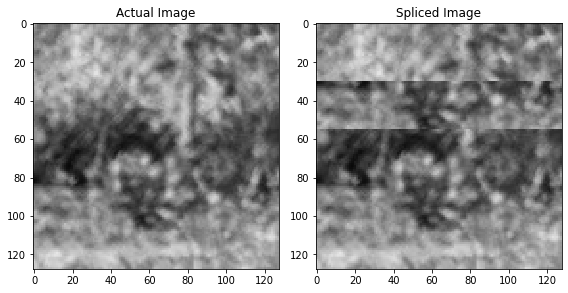

In [12]:
#Display the authentic and Spliced input images

img_auth = io.imread(PATH_TO_AUTHENTIC_IMG)
img_spl = io.imread(PATH_TO_SPLICED_IMG)

fig = plt.figure(figsize=(8,8));
ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text('Actual Image')
io.imshow(img_auth)
ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('Spliced Image')
io.imshow(img_spl)


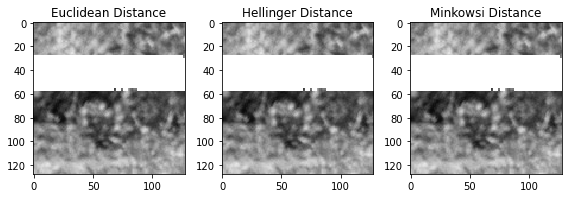

In [24]:
# Display the output images (spliced part colored)

#filepath for diksham1
#PATH_TO_EUCLIDEAN_DISTANCE = 'euclidean.bmp'
#PATH_TO_HELLINGER_DISTANCE = 'hellinger.bmp'
#PATH_TO_MINKOWSKI_DISTANCE = 'minkowski.bmp'

#filepath for lanukahjo
PATH_TO_EUCLIDEAN_DISTANCE = os.getcwd() + "/Dataset/Output" + base_file_name + "_S_E.bmp"
PATH_TO_HELLINGER_DISTANCE = os.getcwd() + "/Dataset/Output" + base_file_name + "_S_H.bmp"
PATH_TO_MINKOWSKI_DISTANCE = os.getcwd() + "/Dataset/Output" + base_file_name + "_S_M.bmp"

img_euclidean = io.imread(PATH_TO_EUCLIDEAN_DISTANCE)
img_hellinger = io.imread(PATH_TO_HELLINGER_DISTANCE)
img_minkowski = io.imread(PATH_TO_MINKOWSKI_DISTANCE)

fig = plt.figure(figsize=(8,8));
ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Euclidean Distance')
io.imshow(img_euclidean)
ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Hellinger Distance')
io.imshow(img_hellinger)
ax2 = fig.add_subplot(1,3,3)
ax2.title.set_text('Minkowsi Distance')
io.imshow(img_minkowski)
